# Binary classification

## Context

This dataset includes measurements of Palmer penguins, along with what species of penguin they are. The idea is to classify whether the penguin is a Chinstrap, Gentoo, or Adélie.

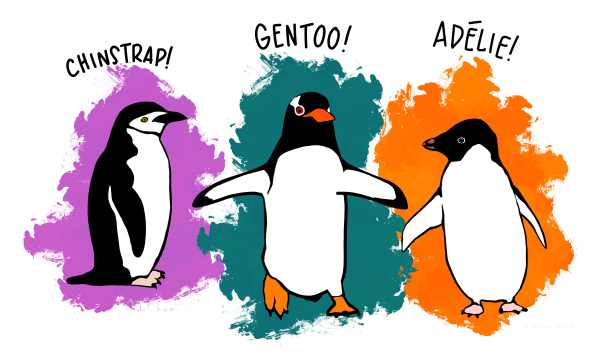
The dataset consists of 7 columns.

- species: penguin species (Chinstrap, Adélie, or Gentoo)  
- culmen_length_mm: culmen length (mm)  
- culmen_depth_mm: culmen depth (mm)  
- flipper_length_mm: flipper length (mm)  
- body_mass_g: body mass (g)  
- island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)  
- sex: penguin sex  

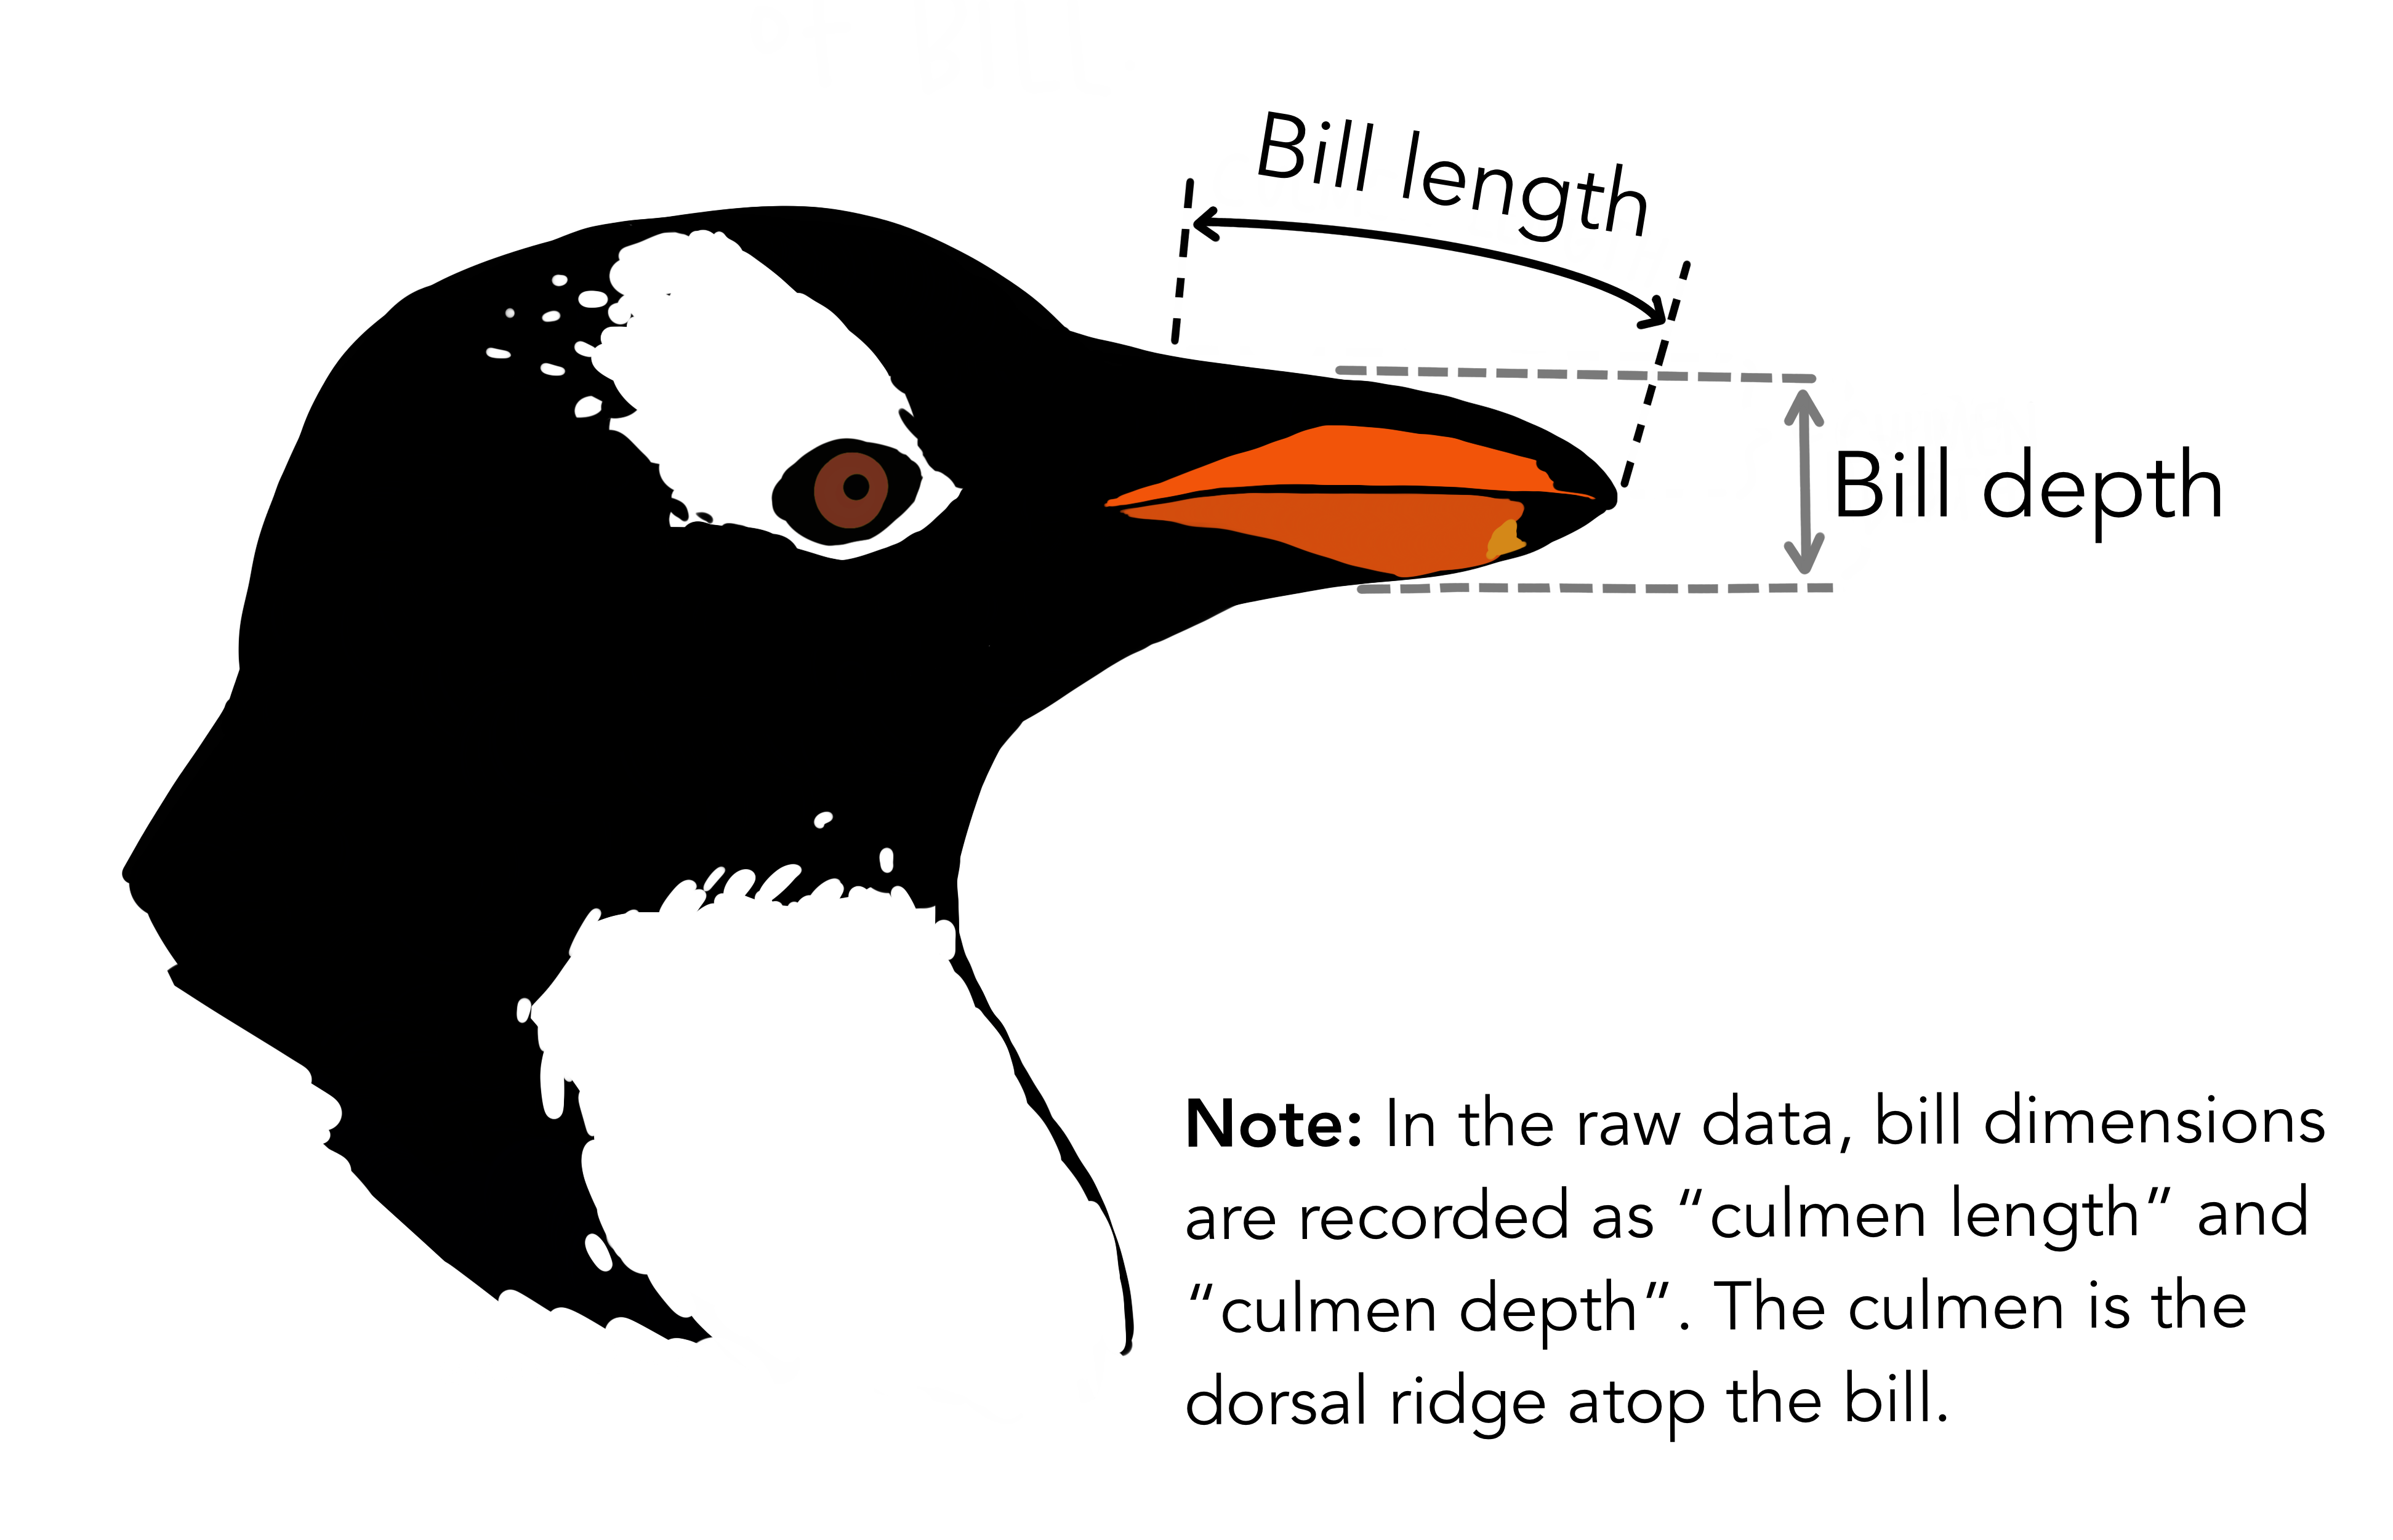

Artwork by @allison_horst  

Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218.

## Reading the dataset

In [54]:
!pip3 install seaborn
!pip3 install opendatasets --upgrade --quiet



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [55]:
import pandas as pd
import numpy as np
##  Go to the Kaggle website and find the data set you want to download. Click Late Submission and agree to the terms and conditions.
##  Copy the URL of the data set and paste it into the code below.
##  Go to https://www.kaggle.com/settings/account and generate a new api token. This will download a kaggle.json file. 
##  Place it in the same directory as this notebook.
import pandas as pd
import opendatasets as od
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data'
# Using opendatasets let's download the data sets
od.download(dataset)
dataset

# Load the data into a pandas dataframe
penguins = pd.read_csv('palmer-archipelago-antarctica-penguin-data/penguins_size.csv')

Skipping, found downloaded files in "./palmer-archipelago-antarctica-penguin-data" (use force=True to force download)


We will remove the Chinstrap species for this excercise (unless you want to implement a Softmax regression).

In [56]:
penguins = penguins[penguins['species'] != 'Chinstrap']

We will also remove the island and sex features/columns for this exercise.

In [57]:
penguins = penguins.drop(['island'], axis = 1)
penguins = penguins.drop(['sex'], axis = 1)

## Explore and clean up the data

# What we will do here

Evolve a solution that is a binary classifier of whether a penguin is a Chinstrap or Gentoo. Remember to check and explore the data before implementing your algorithm.

# Walkthrough

In [58]:
penguins.head(100)

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,NaN,NaN,NaN,NaN
4,Adelie,36.7,19.3,193.0,3450.0
...,...,...,...,...,...
95,Adelie,40.8,18.9,208.0,4300.0
96,Adelie,38.1,18.6,190.0,3700.0
97,Adelie,40.3,18.5,196.0,4350.0
98,Adelie,33.1,16.1,178.0,2900.0


In [59]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            276 non-null    object 
 1   culmen_length_mm   274 non-null    float64
 2   culmen_depth_mm    274 non-null    float64
 3   flipper_length_mm  274 non-null    float64
 4   body_mass_g        274 non-null    float64
dtypes: float64(4), object(1)
memory usage: 12.9+ KB


In [60]:
penguins.species.value_counts()

species
Adelie    152
Gentoo    124
Name: count, dtype: int64

Looks like the dataset is already reasonably balanced between these two species, but not perfect. We probably don't need to resample here.

In [61]:
penguins = penguins.replace('Adelie',0).replace('Gentoo',1)
penguins = penguins.rename(columns={'species': 'target'})

/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_9243/1946955137.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  penguins = penguins.replace('Adelie',0).replace('Gentoo',1)


In [62]:
penguins.describe(include='all')

,target,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,276.000000,274.000000,274.000000,274.000000,274.000000
mean,0.449275,42.702920,16.836131,202.178832,4318.065693
std,0.498324,5.195566,2.013410,15.047938,835.933105
min,0.000000,32.100000,13.100000,172.000000,2850.000000
25%,0.000000,38.350000,15.000000,190.000000,3600.000000
50%,0.000000,42.000000,17.000000,198.000000,4262.500000
75%,1.000000,46.675000,18.500000,215.000000,4950.000000
max,1.000000,59.600000,21.500000,231.000000,6300.000000


Check for missing data

In [63]:
penguins.isnull().sum()

target               0
culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
dtype: int64

Looks like there is missing data. We will use a simple imputation procedure to replace the missing data. Here, we only have numeric features and take a basic approach of replacing missing data with the mean of that measurement.

In [64]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
penguins.iloc[:,1:] = imputer.fit_transform(penguins.iloc[:,1:])

In [65]:
penguins.describe(include='all')

,target,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,276.000000,276.000000,276.000000,276.000000,276.000000
mean,0.449275,42.702920,16.836131,202.178832,4318.065693
std,0.498324,5.176639,2.006075,14.993118,832.887802
min,0.000000,32.100000,13.100000,172.000000,2850.000000
25%,0.000000,38.450000,15.000000,190.000000,3600.000000
50%,0.000000,42.050000,17.000000,198.500000,4287.500000
75%,1.000000,46.625000,18.500000,215.000000,4950.000000
max,1.000000,59.600000,21.500000,231.000000,6300.000000


<Axes: >

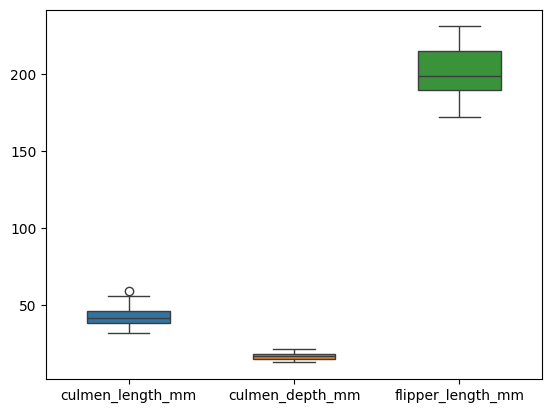

In [66]:
import seaborn as sns
sns.boxplot(data=penguins.iloc[:,1:4], width=0.5)

<Axes: xlabel='target', ylabel='culmen_length_mm'>

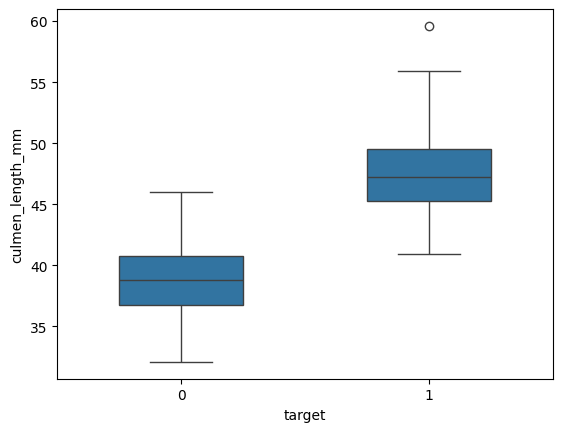

In [67]:
sns.boxplot(x="target", y="culmen_length_mm", data=penguins, width=0.5)

<Axes: xlabel='target', ylabel='culmen_depth_mm'>

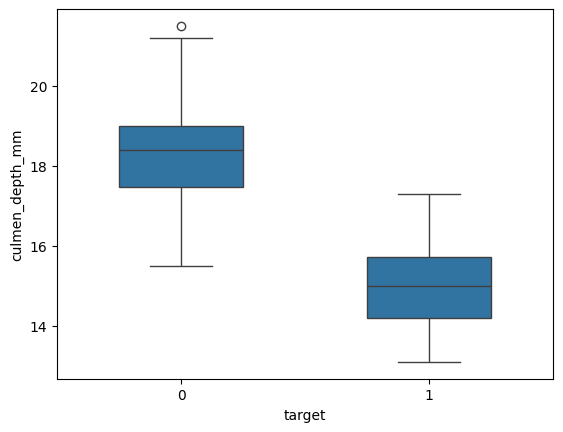

In [68]:
sns.boxplot(x="target", y="culmen_depth_mm", data=penguins, width=0.5)

Note that if you were going to include these figures in a report they would need tidying up first!

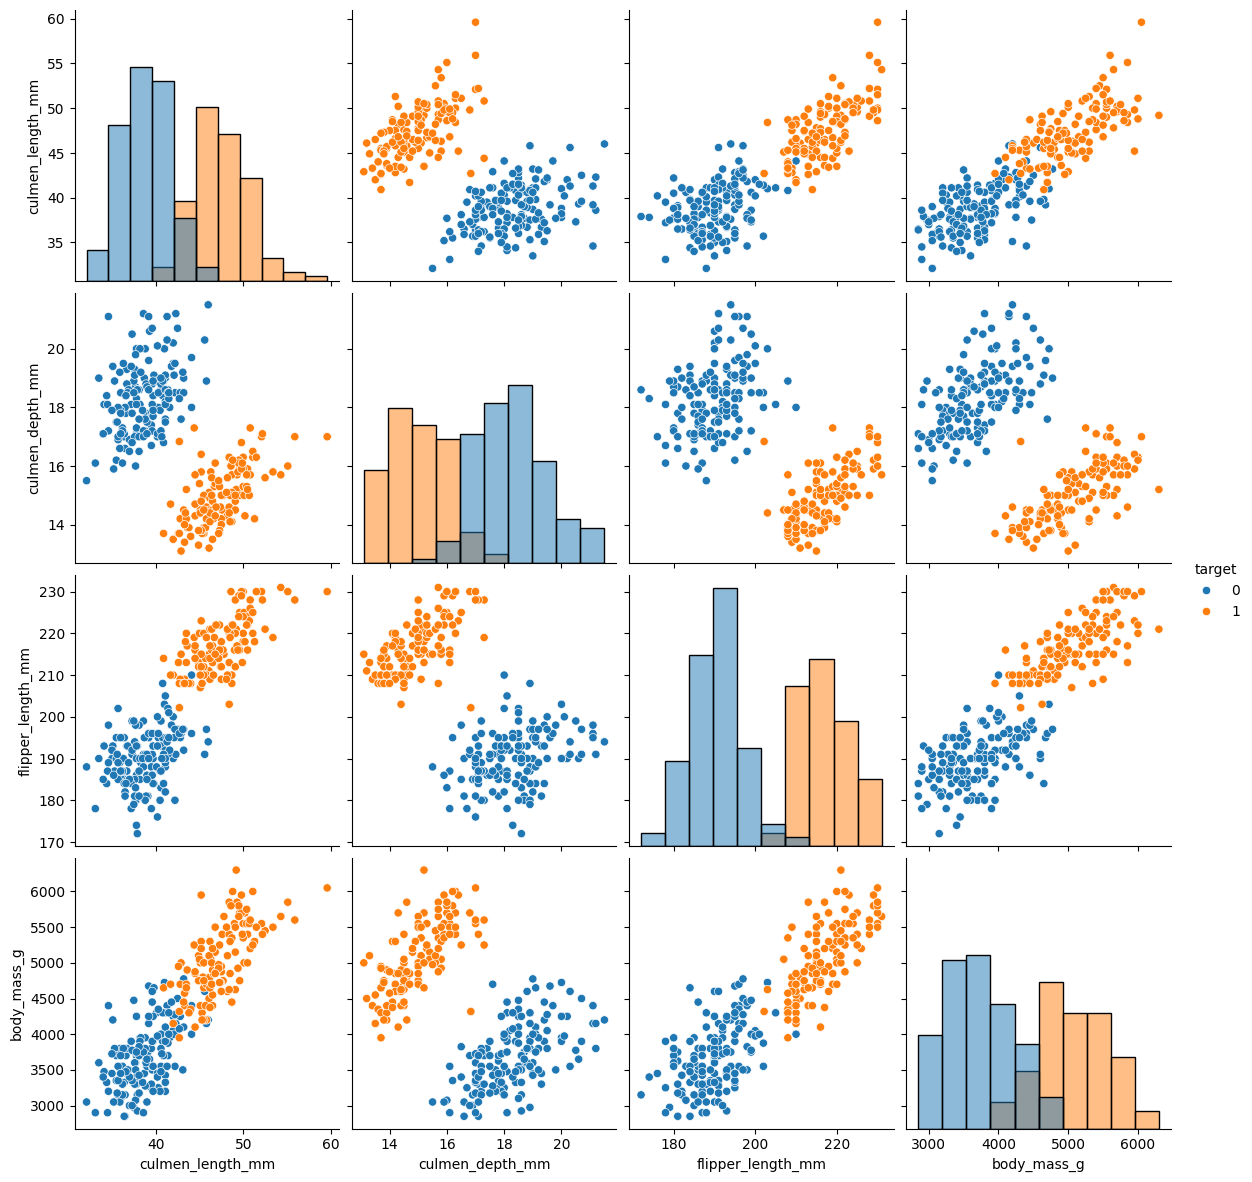

In [69]:
sns.pairplot(penguins, hue="target", height=3,diag_kind="hist")

## Prepare the data for our algorithm

Divide into target and features

In [70]:
X = penguins.drop(labels='target', axis=1)
y = penguins['target']

We now need to split into train and test sets. For this, we use a stratified split. This tries to keep the same ratio of each target category in the train and test sets. We're doing this because the dataset is small.

In [71]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits = 1, test_size=0.3)
ss.get_n_splits(penguins)

for train_index, test_index in ss.split(X,y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

In [72]:
y_train.value_counts()

target
0    106
1     87
Name: count, dtype: int64

In [73]:
y_test.value_counts()

target
0    46
1    37
Name: count, dtype: int64

You can see that the split keeps a similar ratio of each species in both the training and test sets.

# Evolutionary algorithm

In [74]:
!pip install deap

zsh:1: command not found: pip


In [75]:
from deap import base
from deap import creator
from deap import tools
import random

In [76]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [77]:
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

We need to decide on a representation for our individuals, and will use the GA to optimise a regression model. This means that an individual simply represents the weights with which to multiply the features.

For continuous features you can capture non-linearities. Which you can do e.g. using polynomials. Here, we will just keep it simple to illustrate the concept.

This means that we will need individuals to represent 1 weight for each of the four features in the dataset. It is also a good idea to add an intercept. Thus, individuals will have five genes.

We need to define a function that gives a classification for an individual, on a given row in the dataset. For that we use a logistic regression. However, because we want a first prediction (0 or 1) rather than probability, we could apply a threshold at 0.5, to make it a binary regression.

In [78]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def prediction(individual,row):
    regr = individual[0] + sum(i * r for i , r in zip(individual[1:4], row ) )
    return( float(sigmoid(regr)) )

This represents the model:  

y = a + x1w1 + x2w2 + x3w3 + x4w4

y = (sigmoid(y) > 0.5)

Where a is the intercept xi is the feature/column and wi is the weight from the individual that we are evolving.

In [79]:

# def evalAccuracyTrain(individual, X_train, y_train):
#     y_pred = [None] * X_train.shape[0]

#     index = 0
#     for i, row in X_train.iterrows():
#         y_pred[index] = prediction(individual,row)
#         index += 1

#     return( sum(diff), )

# Define BinaryCrossEntropy function
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    term_0 = (1 - y_true) * np.log(1 - y_pred)
    term_1 = y_true * np.log(y_pred)
    return -np.mean(term_0 + term_1)

# Define evaluation function for DEAP
def evalAccuracyTrain(individual, X_train, y_train):
    # Here, individual represents your neural network weights or parameters
    y_pred = [None] * X_train.shape[0]

    index = 0
    for i, row in X_train.iterrows():
        y_pred[index] = prediction(individual,row)
        index += 1
    loss = BinaryCrossEntropy(y_train, y_pred)  # Calculate BinaryCrossEntropy loss
    return loss,


Normally logistic regression does not use mean squared error (commonly used in linear regression) because it makes the landscape have some local optima. However, this will be fine for this problem.

In [80]:
toolbox.register("evaluate", evalAccuracyTrain)

Let's test our evaluation function before we use it

In [81]:
import random
indv1 = [random.random() for iter in range(5)]

In [82]:
y_pred = [None] * penguins.shape[0]

In [83]:
prediction(indv1,X_train.iloc[50])

1.0

In [84]:
prediction(indv1,X_train.iloc[50]) > 0.5

True

Let's carry on with the GA

Now we register our operators. We are using a per-gene probability of mutation here, and we have 5 genes. So ba careful not to have mutation so high that you can almost always mutate an individual. You need to preserve some of what you have found.

In [85]:
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.4, indpb=0.2)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("select", tools.selTournament, tournsize=3)

In [86]:
NGEN, CXPB = 30, 0.2
pop = toolbox.population(n=200)

fitnesses = [toolbox.evaluate(ind, X_train, y_train) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [87]:
for g in range(NGEN):
    print("-- Generation %i --" % g)
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    invalid_inds = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(ind, X_train, y_train) for ind in invalid_inds]
    for ind, fit in zip(invalid_inds, fitnesses):
        ind.fitness.values = fit

    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    pop[:] = offspring

-- Generation 0 --
Best individual is [-0.19427183196727027, 0.22253555749281806, -0.7826010754141364, 0.023375087391469762, 0.5471619811996311], (0.16971053609611841,)
-- Generation 1 --
Best individual is [-0.5063910060974395, 0.03307710427128405, -0.7053863352096605, 0.049420286149383985, -0.5428588483650094], (0.16858364351441002,)
-- Generation 2 --
Best individual is [-0.27115030028471643, -0.038430397310293074, -0.9151356532640718, 0.08108579391194423, 0.6220495339318842], (0.12100683739364433,)
-- Generation 3 --
Best individual is [-0.5063910060974395, 0.11093875226006045, -0.8980903507087987, 0.049420286149383985, -0.23542639628188627], (0.09670564656100898,)
-- Generation 4 --
Best individual is [0.6504058397797309, 0.22634031480133576, -1.4076704456670042, 0.05711653904429448, -0.9591545901287339], (0.05313433595673244,)
-- Generation 5 --
Best individual is [0.6504058397797309, 0.22634031480133576, -1.4076704456670042, 0.05711653904429448, -0.9591545901287339], (0.05313433

# Examine

In [88]:
from sklearn.metrics import accuracy_score

y_pred = [None] * X_test.shape[0]
index = 0
for i, row in X_test.iterrows():
    y_pred[index] = prediction(best_ind,row)
    index += 1

y_bin_pred = np.array(y_pred) > 0.5
accuracy = accuracy_score(y_test, y_bin_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 98.80%
